# Initializations

In [1]:
from glob import glob

import warnings
warnings.filterwarnings("ignore")

import matplotlib.pyplot as plt
import seaborn as sns

import random
import numpy as np
import pandas as pd
import os
import copy

import re

import cv2

from tqdm import tqdm
import gc
import pydicom as dcm
import nibabel as nib

import torchvision
import torchvision.transforms.v2 as T
import albumentations as A
from albumentations.core.transforms_interface import DualTransform

def set_device():
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    print(device)
    return device    

def set_data_paths():
    data_path = {}
    data_path['root'] = '/kaggle/input/rsna-2023-abdominal-trauma-detection'
    data_path['train'] = '/kaggle/input/rsna-2023-abdominal-trauma-detection/train_images'
    data_path['segmentations'] = '/kaggle/input/rsna-2023-abdominal-trauma-detection/segmentations'
    data_path['test'] = '/kaggle/input/rsna-2023-abdominal-trauma-detection/test_images'
    data_path['masks'] = '/kaggle/working/mask_slices'
    return data_path

def create_segmentation_dict():
    # Mask organ label mapping
    segmentation_dict = {}
    segmentation_dict['segmentation_class_to_inx'] = {'Background': 0, 'Liver': 1, 'Spleen': 2, 'Kidney_left': 3, 'Kidney_right': 4, 'Bowel': 5}
    segmentation_dict['segmentaiton_inx_to_class'] = {0: 'Background', 1: 'Liver', 2:'Spleen', 3:'Kidney_left', 4:'Kidney_right', 5 :'Bowel'}
    segmentation_dict['final_output'] = ['Background', 'Bowel', 'Kidney' , 'Liver' , 'Spleen']
    return segmentation_dict

# ________________________________________________________________________________________________________________ DATA PREPROCESSING
def sorted_dcm_labels(folder):
    try:
        filenames = os.listdir(folder)
        names = sorted( [int(filename.split('.')[0]) for filename in filenames] )
        return names
    except:
        return []


def standardize_pixel_array(dcm: dcm.dataset.FileDataset) -> np.ndarray:
    # Correct DICOM pixel_array if PixelRepresentation == 1.
    pixel_array = dcm.pixel_array
    if dcm.PixelRepresentation == 1:
        bit_shift = dcm.BitsAllocated - dcm.BitsStored
        dtype = pixel_array.dtype 
        pixel_array = (pixel_array << bit_shift).astype(dtype) >>  bit_shift
    return pixel_array

def load_CT_slice(filepath, downsample_rate=1):
    ds = dcm.dcmread(filepath)
    image = standardize_pixel_array(ds)
            
    # find rescale params
    if ("RescaleIntercept" in ds) and ("RescaleSlope" in ds):
        intercept = float(ds.RescaleIntercept)
        slope = float(ds.RescaleSlope)

    # find clipping params
    center = int(ds.WindowCenter)
    width = int(ds.WindowWidth)
    low = center - width / 2
    high = center + width / 2    

    image = (image * slope) + intercept
    image = np.clip(image, low, high)
    image = image - image.min()
    if image.max() > 0:
        image = (image / image.max() ).astype(np.float64)
    image = image[::downsample_rate, ::downsample_rate]
    
    return image


def get_z_acquisition_direction(session_path):
    instances = sorted_dcm_labels(session_path)
    
    # extract z_start
    instance_start = instances[0]
    filepath = session_path + '/' + str(instance_start) + '.dcm'
    z_start = dcm.dcmread( filepath ).ImagePositionPatient[-1]
    # extract z_end
    instance_end = instances[-1]
    filepath = session_path + '/' + str(instance_end) + '.dcm'
    z_end = dcm.dcmread( filepath ).ImagePositionPatient[-1]
        
    if z_end < z_start:
        return 'downward'
    else:
        return 'upward'
    
    
def create_3D_segmentations(filepath, downsample_rate=1):
    img = nib.load(filepath).get_fdata().astype(np.int8)
    img = np.transpose(img, [1, 0, 2])
    img = np.rot90(img, 1, (1,2))
    img = img[::-1,:,:]
    img = np.transpose(img, [1, 0, 2])
    img = img[::downsample_rate, ::downsample_rate, ::downsample_rate]
    return img


def CT_remove_distractions(img):
    img = cv2.cvtColor(img, cv2.COLOR_GRAY2BGR)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    img = cv2.normalize(img, None, alpha = 0, beta = 255, norm_type = cv2.NORM_MINMAX, dtype = cv2.CV_8U)

    thresh = cv2.threshold(img, 2, 255, cv2.THRESH_BINARY)[1]
    output = cv2.connectedComponentsWithStats(thresh, cv2.CV_32S)
    (numLabels, labels, stats, centroids) = output
    components = {label: (labels == label).sum() for label in sorted(np.unique(labels))}

    good_components = np.argsort(list(components.values()))[::-1][:2]
    good_areas = np.isin(labels, good_components)

    img_clean = img * good_areas
    return img_clean

def CT_crop_background(img):
    i, j = np.where(img > 5)
    i_min = i.min()
    i_max = i.max()
    j_min = j.min()
    j_max = j.max()
    
    img_cropped = img[i_min:i_max, j_min:j_max]
    return img_cropped, (i_min, i_max, j_min, j_max)

class Clean_CT(DualTransform):

    def __init__(self, image_size=None, always_apply=True, p=1.0):
        super().__init__(always_apply, p)
        self.borders = None
        self.image_size = image_size
        
    def apply(self, img, **params):
        img = img.copy()
        img = np.array(img)
        img_clean = CT_remove_distractions(img)
        img_clean_cropped, self.borders = CT_crop_background(img_clean)
        img_clean_cropped_resized = A.Compose([
            A.Resize(int(self.image_size[1]*0.7), self.image_size[1] - 10, interpolation=cv2.INTER_NEAREST_EXACT),
            A.PadIfNeeded(min_height=self.image_size[0], min_width=self.image_size[1], p=1, border_mode=cv2.BORDER_CONSTANT, value=0)
        ])(image=img_clean_cropped)['image']
        return img_clean_cropped_resized
    
    def apply_to_mask(self, mask, fill_value=0, **params):
        mask = mask.copy()
        mask = np.array(mask)
        mask = mask[self.borders[0]:self.borders[1], self.borders[2]:self.borders[3]]
        mask = A.Compose([
            A.Resize(int(self.image_size[1]*0.7), self.image_size[1] - 10, interpolation=cv2.INTER_NEAREST_EXACT),
            A.PadIfNeeded(min_height=self.image_size[0], min_width=self.image_size[1], p=1, border_mode=cv2.BORDER_CONSTANT, value=fill_value)
        ])(image=mask)['image']
        return mask
    
    def apply_to_masks(self, masks, **params):
        out = []
        for ind, mask in enumerate(masks):
            if ind == 0: # background
                val = 1.0
            else: 
                val = 0.0
            out.append( self.apply_to_mask(mask, fill_value=val, **params) )
        return out
    
    
def create_augmentations(organ, filenames, transform_list, repetitions=1):  
    images_dict = {} # create a dict for albumentation transform function
    filenames_dict = {} # relates image key to filename to relate Albumentation output to filename
    
    for ind, filename in enumerate(filenames):
        filepath = os.path.join(series_path, filename)
        img = cv2.imread(filepath, cv2.COLOR_BGRA2GRAY)
        
        if organ == 'Background':
            img = np.where(img == 0, np.nan, img)
            img_minimum = np.nanmin(img)
            img = np.where(np.isnan(img), img_minimum, img)
            img = cv2.normalize(img, None, alpha = 0, beta = 255, norm_type = cv2.NORM_MINMAX, dtype=cv2.CV_8U)
            
        if ind == 0:
            image_key = 'image'
        else:
            image_key = 'image'+str(ind+1)
            
        images_dict[image_key] = img
        filenames_dict[image_key] = filename
        
        
        
    # ----------- transform images
    transform = A.Compose(transform_list
    , additional_targets={key: 'image' for key in list(images_dict.keys())[1:]})
    
    # ----------- Output augmentations
    augmentations = []
    for _ in range(repetitions):
        out = transform(**images_dict)
        augmentation = {filenames_dict[key]: val for key, val in out.items()}
        augmentations.append( augmentation )
    
    reals = {key: val for key, val in zip(filenames, images_dict.values())}
    return reals, augmentations



def plot_augmentations(reals, augs, title=False):
    fig, ax = plt.subplots(2, 15, figsize=(20, 6))
    ax = ax.ravel()
    for ind, (filename, image) in enumerate(reals.items()):
        ax[ind].imshow(image, cmap='gray')
        ax[ind].axis('off')
        if title:
            ax[ind].set_title( filename.split('.')[0] )
    fig.tight_layout(h_pad=0.2, w_pad=0.2)
    fig.suptitle('Real images')

    
    for aug_ind, aug in enumerate(augs):
        fig, ax = plt.subplots(2, 15, figsize=(20, 6))
        ax = ax.ravel()
        for ind, (filename, image) in enumerate(aug.items()):
            ax[ind].imshow( image, cmap='gray')
            ax[ind].axis('off')
            if title:
                ax[ind].set_title( filename.split('.')[0] )
        fig.tight_layout(h_pad=0.2, w_pad=0.2)
        fig.suptitle('augmentation '+str(aug_ind))

# investigate Extravasation slices

In [7]:
df = pd.read_csv('/kaggle/input/rsna-2023-abdominal-trauma-detection/image_level_labels.csv')

In [8]:
def get_slice_range(row):
    path = os.path.join('/kaggle/input/rsna-2023-abdominal-trauma-detection/train_images/', str(row['patient_id']), str(row['series_id']))
    filenames = os.listdir(path)
    a = sorted( [int( name.split('.')[0] ) for name in filenames] )
    return a[0], a[-1]

# find range of injuries
df_min = df.groupby(['patient_id', 'series_id', 'injury_name'])['instance_number'].min()
df_max = df.groupby(['patient_id', 'series_id', 'injury_name'])['instance_number'].max()
df_slices = pd.concat([df_min, df_max], axis=1)
df_slices.columns = ['first_injury_slice', 'last_injury_slice']
df_slices['injury_range'] = df_slices['last_injury_slice'] - df_slices['first_injury_slice'] + 1

# find range of actual dcms
df_slices = df_slices.reset_index()
df_slices['first_dcm_slice'] = df_slices.apply(lambda row: get_slice_range(row)[0], axis=1)
df_slices['last_dcm_slice'] = df_slices.apply(lambda row: get_slice_range(row)[1], axis=1)
df_slices['dcm_range'] = df_slices['last_dcm_slice'] - df_slices['first_dcm_slice'] + 1
df_slices.head(20)

,patient_id,series_id,injury_name,first_injury_slice,last_injury_slice,injury_range,first_dcm_slice,last_dcm_slice,dcm_range
0,33,55570,Active_Extravasation,110,110,1,19,223,205
1,33,55570,Bowel,93,127,35,19,223,205
2,43,24055,Active_Extravasation,106,108,3,2,217,216
3,43,24055,Bowel,97,146,50,2,217,216
4,263,44610,Active_Extravasation,143,183,41,13,203,191
5,820,11921,Active_Extravasation,86,90,5,1,187,187
6,820,11921,Bowel,75,102,28,1,187,187
7,820,38809,Active_Extravasation,205,208,4,103,336,234
8,820,38809,Bowel,194,227,34,103,336,234
9,1675,15870,Active_Extravasation,298,298,1,1,665,665


Text(0.5, 1.0, 'range of slices in each injury per session')

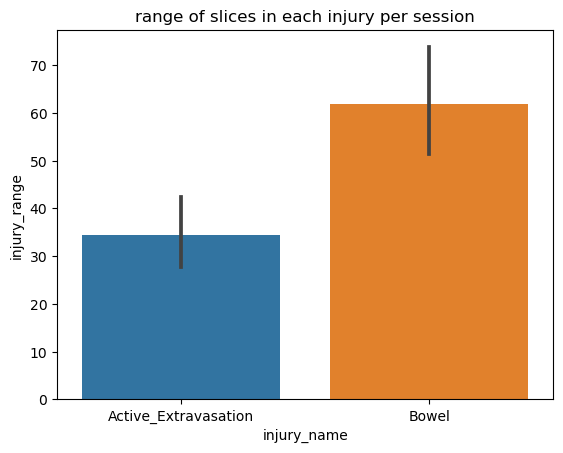

In [4]:
sns.barplot(df_slices, x='injury_name', y='injury_range')
plt.title('range of slices in each injury per session')

### plot in comparison to dcm images

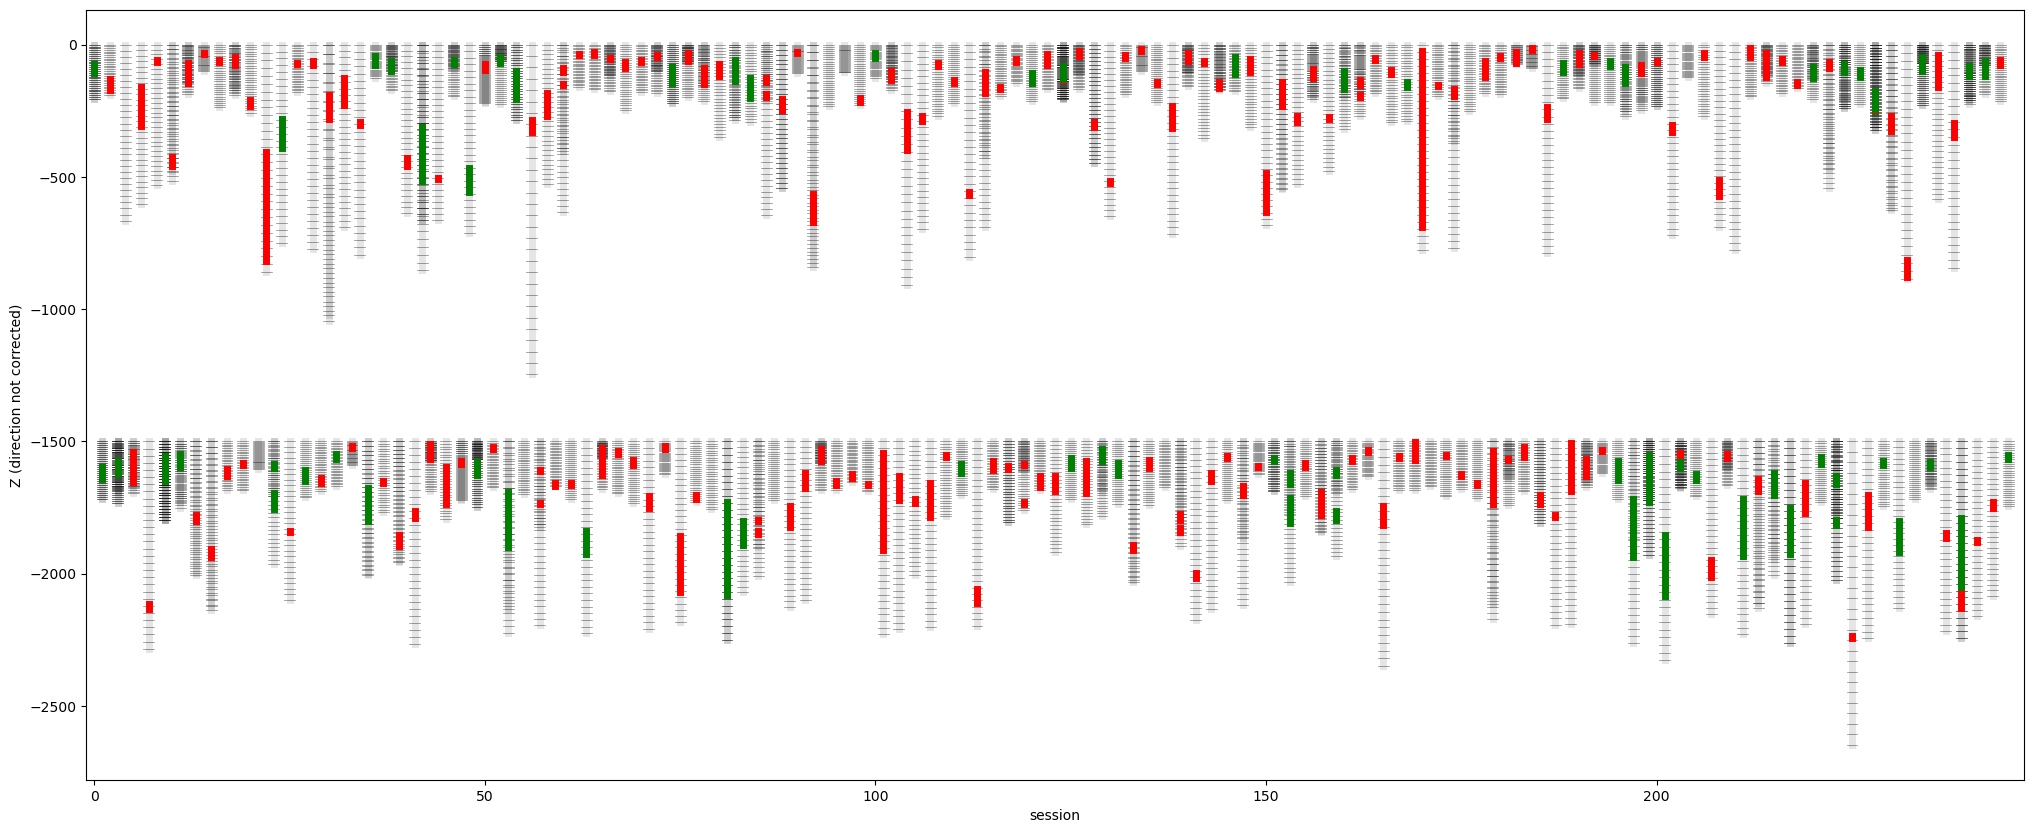

In [5]:
patient_list = sorted(df_slices['patient_id'].unique().tolist())

plt.figure(figsize=(25, 10))
for ind, row in df_slices.iterrows():
    # find patient location in plot
    x = patient_list.index(row['patient_id'])

    # to split subjects across two rows because they are a lot to plot
    if x % 2:
        shift = 1500
    else:
        shift = 0
        
    # plot dcm label range
    plt.plot([x, x], [-row['dcm_range']-shift, -shift], 'k', linewidth=5, alpha=0.1, zorder=-1)
    
    # plot 30 images
    samples = np.linspace(0, row['dcm_range'], 30)
    for sample in samples:
        plt.plot([x-0.7, x+0.7], [-sample-shift, -sample-shift], 'k', linewidth=0.5, alpha=0.5, zorder=-1)
    
    # plot injuries
    a = row['first_injury_slice'] - row['first_dcm_slice'] + shift
    b = row['last_injury_slice'] - row['first_dcm_slice'] + shift
    if row['injury_name'] == 'Bowel':
        plt.plot([x, x], [-b, -a], linewidth=5, alpha=1, color='g')
    elif row['injury_name'] == 'Active_Extravasation':
        plt.plot([x, x], [-b, -a], linewidth=5, alpha=1, color='r')

plt.xlim([-1, len(patient_list)+1])
_ = plt.xlabel('session')
_ = plt.ylabel('Z (direction not corrected)')

# Check input of CNN for each patient/healthy group

In [9]:
df = pd.read_parquet('/kaggle/input/unet256clean-masks-v2/patient_list_per_series.parquet')
df

,patient_id,series_id,instances,bowel_healthy,bowel_injury,extravasation_healthy,extravasation_injury,kidney_healthy,kidney_low,kidney_high,liver_healthy,liver_low,liver_high,spleen_healthy,spleen_low,spleen_high,high_hu,any_injury
0,26501,22032,"[2, 131, 8, 137, 14, 144, 21, 150, 27, 157, 34...",True,False,True,False,True,False,False,True,False,False,True,False,False,False,False
1,26501,31614,"[128, 131, 45, 47, 50, 53, 56, 59, 62, 65, 68,...",True,False,True,False,True,False,False,True,False,False,True,False,False,True,False
2,32627,51693,"[641, 266, 523, 781, 149, 406, 664, 289, 547, ...",True,False,True,False,True,False,False,False,True,False,True,False,False,False,True
3,44515,12236,"[256, 386, 265, 396, 274, 405, 284, 414, 293, ...",True,False,True,False,True,False,False,True,False,False,True,False,False,True,False
4,44515,2942,"[1, 393, 138, 530, 275, 20, 412, 157, 549, 295...",True,False,True,False,True,False,False,True,False,False,True,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4700,37028,45013,"[907, 780, 654, 527, 400, 274, 932, 806, 679, ...",True,False,True,False,True,False,False,True,False,False,True,False,False,True,False
4701,18404,18437,"[258, 131, 139, 146, 154, 161, 168, 42, 176, 4...",True,False,True,False,False,True,False,True,False,False,True,False,False,False,True
4702,30698,26709,"[128, 134, 140, 146, 152, 158, 164, 38, 170, 4...",True,False,False,True,True,False,False,False,True,False,True,False,False,False,True
4703,31034,48129,"[257, 387, 518, 648, 779, 278, 409, 540, 670, ...",True,False,True,False,True,False,False,True,False,False,False,True,False,False,True


Plot patients

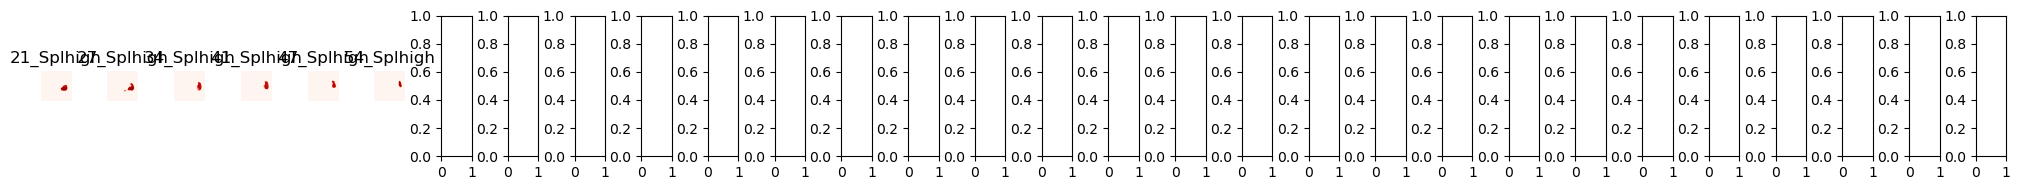

In [10]:
organ = 'Spleen'

if organ == 'Extravasation':
    organ_key = 'Background'
else:
    organ_key = organ
    
df_patient = df.loc[df[organ.lower()+'_healthy']==False, :].sample(frac=1)
df_healthy = df.loc[df[organ.lower()+'_healthy']==True, :].sample(frac=1)

df_temp = df_patient

for ind in range(2):
    patient_id = df_temp.iloc[ind, :]['patient_id']
    serie_id = df_temp.iloc[ind, :]['series_id']
    
    if organ not in ['Extravasation', 'Bowel']:
        condition = 'healthy' if df_temp.equals(df_healthy) else 'high' if df_temp.iloc[ind, :][organ.lower()+'_high'] else 'low'
    else:
        condition = 'injured' if df_temp.iloc[ind, :][organ.lower()+'_injury'] else 'healthy'
        
    serie_path = os.path.join('/kaggle/input/unet256clean-masks-v2/unet256clean_masks/unet256clean_masks', str(patient_id), str(serie_id))
    filenames = os.listdir( serie_path )
    filenames = [file for file in filenames if organ_key in file]
    files = sorted( [int(file.split('_')[0]) for file in filenames] )
    filenames = [str(file)+ '_' + organ_key + '.png' for file in files]
    if len(filenames) == 0:
        continue
        
    fig, ax = plt.subplots(1, 30, figsize=(20,2))
    ax = ax.ravel()
    counter = 0
    for filename in filenames:
        filepath = serie_path + '/' + filename
        img = cv2.imread(filepath, cv2.COLOR_GRAY2RGB)

#         if (np.array(img).sum()>0) and (counter<10):
        ax[counter].imshow(img, cmap='Reds', vmin=0, vmax=255)
        ax[counter].set_title(filename.split('.')[0][:6] + condition)
        ax[counter].axis('off')
#         else:
#             ax[counter].set_visible(False)
#             ax[counter].axis('off')
        counter += 1
        
    fig.tight_layout(w_pad=0, h_pad=0.1)

# Augment some data for patients

### Create parquet for database including augmented images

In [2]:
# how many augmentations you need?
num_augs = 20
df = pd.read_parquet('/kaggle/input/unet256clean-masks-v2/patient_list_per_series.parquet')

df_total = df.loc[df.index.repeat(num_augs+1)].reset_index(drop=True).copy()
df_total['aug_number'] = np.tile(np.arange(num_augs+1), df.shape[0])
df_total['patient_id'] = df_total.apply(lambda row: str(row['patient_id'])+'_aug'+str(row['aug_number']) if row['aug_number'] > 0 else row['patient_id'], axis=1)

df_total = df_total.loc[(df_total['any_injury'] == True) | (df_total['aug_number'] == 0), :]
print(df_total.shape)

df_total['patient_id'] = df_total['patient_id'].astype(str)
df_total['series_id'] = df_total['series_id'].astype(str)
df_total['aug_number'] = df_total['aug_number'].astype('category')

df_total.to_parquet('patient_list_per_series_with_augs.parquet')

(30465, 19)


In [3]:
df_total

,patient_id,series_id,instances,bowel_healthy,bowel_injury,extravasation_healthy,extravasation_injury,kidney_healthy,kidney_low,kidney_high,liver_healthy,liver_low,liver_high,spleen_healthy,spleen_low,spleen_high,high_hu,any_injury,aug_number
0,26501,22032,"[2, 131, 8, 137, 14, 144, 21, 150, 27, 157, 34...",True,False,True,False,True,False,False,True,False,False,True,False,False,False,False,0
21,26501,31614,"[128, 131, 45, 47, 50, 53, 56, 59, 62, 65, 68,...",True,False,True,False,True,False,False,True,False,False,True,False,False,True,False,0
42,32627,51693,"[641, 266, 523, 781, 149, 406, 664, 289, 547, ...",True,False,True,False,True,False,False,False,True,False,True,False,False,False,True,0
43,32627_aug1,51693,"[641, 266, 523, 781, 149, 406, 664, 289, 547, ...",True,False,True,False,True,False,False,False,True,False,True,False,False,False,True,1
44,32627_aug2,51693,"[641, 266, 523, 781, 149, 406, 664, 289, 547, ...",True,False,True,False,True,False,False,False,True,False,True,False,False,False,True,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
98780,31034_aug17,48129,"[257, 387, 518, 648, 779, 278, 409, 540, 670, ...",True,False,True,False,True,False,False,True,False,False,False,True,False,False,True,17
98781,31034_aug18,48129,"[257, 387, 518, 648, 779, 278, 409, 540, 670, ...",True,False,True,False,True,False,False,True,False,False,False,True,False,False,True,18
98782,31034_aug19,48129,"[257, 387, 518, 648, 779, 278, 409, 540, 670, ...",True,False,True,False,True,False,False,True,False,False,False,True,False,False,True,19
98783,31034_aug20,48129,"[257, 387, 518, 648, 779, 278, 409, 540, 670, ...",True,False,True,False,True,False,False,True,False,False,False,True,False,False,True,20


### Define transforms

In [12]:
input_path = '/kaggle/input/unet256clean-masks-v2/unet256clean_masks/unet256clean_masks'
output_path = '/kaggle/working/unet256clean-masks_with_augs'

transform_list = {}
transform_list['Background'] = [
    A.Affine(scale=(0.8, 1), rotate=(-10, 10), translate_px={'x':(-10, 10), 'y':(-20, 20)}, shear={'x':(-10, 10), 'y':(-10, 10)}, p=0.5),
    A.ElasticTransform(alpha=50, sigma=5, alpha_affine=5, interpolation=cv2.INTER_NEAREST, p=0.5),
    A.GridDistortion(num_steps=5, distort_limit=0.3, interpolation=cv2.INTER_NEAREST, normalized=True, p=0.5),
    A.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2, p=0.5),
    A.OneOf([
    A.CLAHE(clip_limit=2),
    A.Sharpen(),
    A.Emboss(),
    ], p=0.5),
]

transform_list['Bowel'] = [
    A.Affine(scale=(0.7, 1.2), translate_px={'x':(-10, 10), 'y':(-10, 10)}, rotate=(-20, 20), shear={'x':(-10, 10), 'y':(-10, 10)}, p=0.5),
    A.ElasticTransform(alpha=50, sigma=5, alpha_affine=5, interpolation=cv2.INTER_NEAREST, p=0.5),
    A.GridDistortion(num_steps=5, distort_limit=0.6, interpolation=cv2.INTER_NEAREST, normalized=True, p=0.5),
    A.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2, p=0.5),
    A.OneOf([
    A.CLAHE(clip_limit=2),
    A.Sharpen(),
    A.Emboss(),
    ], p=0.5),
]

transform_list['Liver'] = [
    A.Affine(scale=(0.7, 1.1), translate_px={'x':(-5, 20), 'y':(-20, 20)}, rotate=(-15, 15), shear={'x':(-15, 15), 'y':(-15, 15)}, p=0.5),
    A.ElasticTransform(alpha=50, sigma=5, alpha_affine=5, interpolation=cv2.INTER_NEAREST, p=0.5),
    A.GridDistortion(num_steps=5, distort_limit=0.5, interpolation=cv2.INTER_NEAREST, normalized=True, p=0.5),
]

transform_list['Kidney'] = [
    A.Affine(scale=(1, 1.5), translate_px={'x':(-10, 10), 'y':(-20, 10)}, rotate=(-15, 15), shear={'x':(-15, 15), 'y':(-15, 15)}, p=0.5),
    A.ElasticTransform(alpha=50, sigma=5, alpha_affine=5, interpolation=cv2.INTER_NEAREST, p=0.5),
    A.GridDistortion(num_steps=5, distort_limit=0.5, interpolation=cv2.INTER_NEAREST, normalized=True, p=0.5),
]

transform_list['Spleen'] = [
    A.Affine(scale=(1, 1.5), translate_px={'x':(-20, -5), 'y':(-20, -5)}, rotate=(-20, 20), shear={'x':(-10, 10), 'y':(-10, 10)}, p=0.5),
    A.ElasticTransform(alpha=70, sigma=5, alpha_affine=5, interpolation=cv2.INTER_NEAREST, p=0.5),
    A.GridDistortion(num_steps=5, distort_limit=0.6, interpolation=cv2.INTER_NEAREST, normalized=True, p=0.5),
    A.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2, p=0.5),
    A.OneOf([
    A.CLAHE(clip_limit=2),
    A.Sharpen(),
    A.Emboss(),
    ], p=0.5),
]

# Create augmentations

In [17]:
organs = ['Background', 'Bowel', 'Kidney', 'Liver', 'Spleen']
organs = ['Kidney']

for organ in organs:

    if organ == 'Background':
        df_patient = df.loc[df['extravasation_healthy']==False, :].sample(frac=1)
    else:
        df_patient = df.loc[df[organ.lower()+'_healthy']==False, :].sample(frac=1)

    patient_list = df_patient['patient_id'].unique().tolist()
    for patient_counter, patient_id in tqdm(enumerate(patient_list)):
        patient_id = patient_id
        all_series_id = df_patient.loc[df_patient['patient_id']==patient_id, 'series_id'].values.tolist()

        for series_counter, series_id in enumerate(all_series_id):
            series_path = os.path.join(input_path, str(patient_id), str(series_id))

            # Read and sort filenames
            filenames = os.listdir( series_path )
            filenames = [filename for filename in filenames if organ in filename]
            files = sorted( [int(file.split('_')[0]) for file in filenames] )
            filenames = [str(file)+ '_' + organ + '.png' for file in files]

            # Organ might not be in this serie (e.g. extravsation)
            if len(filenames) == 0:
                continue

            reals, augs = create_augmentations(organ, filenames, transform_list[organ], repetitions=num_augs)
            
            # save output
            for aug_ind, aug in enumerate(augs):
                for filename, image_aug in aug.items():
                    filename = filename.replace('.', '_aug' + str(aug_ind) + '.')
                    save_path = os.path.join(output_path, str(patient_id), str(series_id))
                    
                    if os.path.exists(save_path) == False:
                        os.makedirs(save_path)
                        
                    cv2.imwrite(os.path.join(save_path, filename), image_aug)

182it [01:18,  2.31it/s]


# Visual inspecting of augmentations

In [ ]:
reals, augs = create_augmentations(organ, filenames, transform_list[organ], repetitions=10)
plot_augmentations(reals, augs)

# save augmentation files

In [18]:
import shutil
shutil.make_archive('unet256clean-masks_with_augs_'+organ, 'zip','/kaggle/working/unet256clean-masks_with_augs')

'/kaggle/working/unet256clean-masks_with_augs_Kidney.zip'